#Table of Contents
* [1. Load data from CSV file to pd.DataFrame](#1.-Load-data-from-CSV-file-to-pd.DataFrame)
* [2. Build `Comlink` object](#2.-Build-`Comlink`-object)
	* [2.1 Very quick, for only one RX level record without metadata](#2.1-Very-quick,-for-only-one-RX-level-record-without-metadata)
	* [2.2 More complex, with only one RX record, but with metadata and tx_rx_pairs](#2.2-More-complex,-with-only-one-RX-record,-but-with-metadata-and-tx_rx_pairs)
* [3. Do full processing in one rush](#3.-Do-full-processing-in-one-rush)


In [12]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
fig_width=8

In [14]:
import pandas as pd

import pycomlink as pycml

# 1. Load data from CSV file to pd.DataFrame

Let's have a look at our csv data file

In [15]:
!head example_data/gap0_gap4_2012.csv

time, rsl
2012-05-01 00:00:00,-40.565
2012-05-01 00:01:00,-40.594
2012-05-01 00:02:00,-40.565
2012-05-01 00:03:00,-40.565
2012-05-01 00:04:00,-40.565
2012-05-01 00:05:00,-40.594
2012-05-01 00:06:00,-40.565
2012-05-01 00:07:00,-40.565
2012-05-01 00:08:00,-40.594


Read it into a DataFrame using `pandas`

In [16]:
df = pd.read_csv('example_data/gap0_gap4_2012.csv',
                parse_dates=True,
                index_col=0)   
df.head()

,rsl
time,
2012-05-01 00:00:00,-40.565
2012-05-01 00:01:00,-40.594
2012-05-01 00:02:00,-40.565
2012-05-01 00:03:00,-40.565
2012-05-01 00:04:00,-40.565


Plot data, e.g. for May 2012

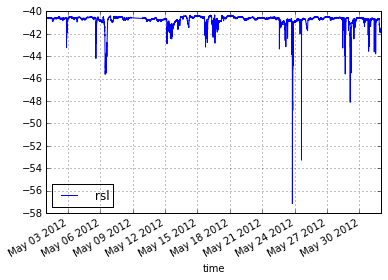

In [17]:
df['2012-05'].plot()

# 2. Build `Comlink` object

## 2.1 Very quick, for only one RX level record without metadata

Comlink directly takes Pandas DataFrame. However, the **columns must be named 'rx' or 'RX'** for freceived signal level and **'tx' or 'TX'** for transmit level. Hence we rename the column `rsl` to `rx`

In [18]:
df.columns = ['rx']
df.head()

,rx
time,
2012-05-01 00:00:00,-40.565
2012-05-01 00:01:00,-40.594
2012-05-01 00:02:00,-40.565
2012-05-01 00:03:00,-40.565
2012-05-01 00:04:00,-40.565


Since `Comlink` need the TX power to calculate the difference, called `txrx`, we can supply the optional argument `const_TX_power`. We use the `Comlink` class and initialize a `Comlink` object which we call `cml`.

In [19]:
cml = pycml.comlink.Comlink(data=df.copy(), 
                            const_TX_power=20)

Let's look at the data in `cml`

In [20]:
cml.data.head()

,rx,tx,txrx_BA
time,,,
2012-05-01 00:00:00,-40.565,20,60.565
2012-05-01 00:01:00,-40.594,20,60.594
2012-05-01 00:02:00,-40.565,20,60.565
2012-05-01 00:03:00,-40.565,20,60.565
2012-05-01 00:04:00,-40.565,20,60.565


`Comlink` automatically calculated TX power minus RX power, because this is the basis for all follwoing processing steps.

Now, let's plot our TX, RX and TXRX time series

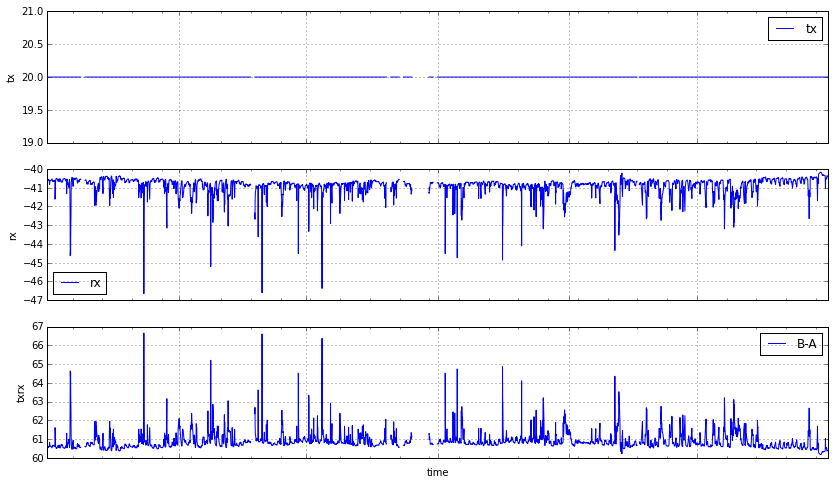

In [21]:
cml.plot(['tx','rx','txrx'],
         resampling_time='H',
         figsize=(14,8));

In [22]:
cml.info()

TypeError: 'NoneType' object has no attribute '__getitem__'

Since we did not supply any metadata, `cml` fails to show its `info`.

But even without metadata wet/dry classification, baseline determination and wet antenna estimation are working. For rain rate calculation, which need the frequency and the length, metadata is needed, though.

## 2.2 More complex, with only one RX record, but with metadata and tx_rx_pairs

`Comlink()` expects the link metadata in a certain format. There are two different sets of "metadata".

1. `metadata` which holds all site specific information, in particular the site locations. But site ID and other stuff, which may be important for you, can be stored here.
2. `tx_rx_pairs` which tell `Comlink()` the exact configuration along the path from one site to the other. Usually, the MW links are Duplex and hence, there are usually two signals along one path. From Site_A to Site_B and the other way round, from Site_B to Site_A.

In [23]:
# An example for the metadata dictonary
metadata = {'site_A': {'lat': 47.5861,
                       'lon': 11.1028,
                       'id': 'oagau1'},
            'site_B': {'lat': 47.493,
                       'lon': 11.0971,
                       'id': 'gap0'},
            'link_id': 'gap0-oagau1',
            'length_km': 10.4}

# An example for a tx_rx_pairs dict. Since here, we only have one direction,
# there is only one key in the main dictonary
tx_rx_pairs =  {'fn': {'name': 'far-near', 
                       'tx': 'tx',
                       'rx': 'rx',
                       'tx_site': 'site_B',
                       'rx_site': 'site_A',
                       'f_GHz': 23.0,
                       'pol': 'V',
                       'linecolor': 'b'}}

Use the above defined dicts to build a new `cml` object. Again we supply the constant TX power. But here we tell `Comlink()` that its column should be named `tx`.

In [24]:
cml = pycml.comlink.Comlink(data=df.copy(),
                            metadata=metadata,
                            tx_rx_pairs=tx_rx_pairs,
                            const_TX_power=('tx',18))

In [25]:
cml.info()

ID: gap0-oagau1
-------------------------------------------------------------
     Site A                       Site B
  f:   --------- 23.0 GHz ---------- 
  L: 10.4 km


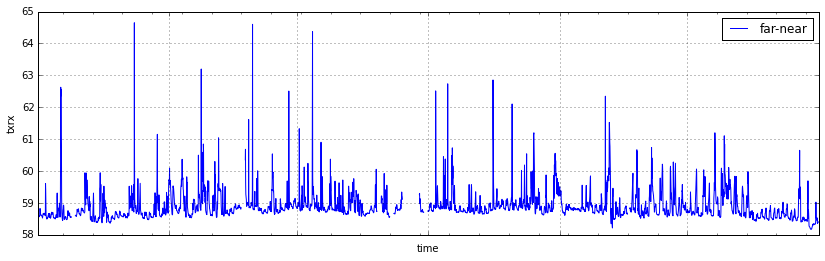

In [26]:
cml.plot('txrx', resampling_time='H', figsize=(14,4));

Limit our analysis to only a short period to make judging the quality of the processing easier

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112155210>]], dtype=object)

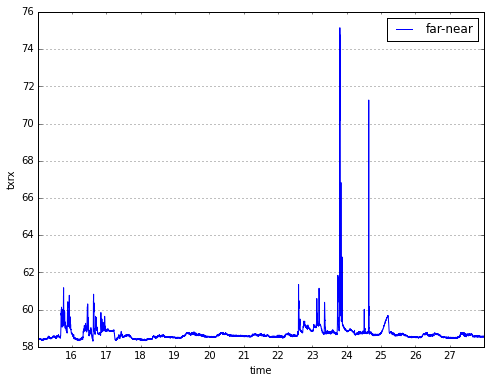

In [31]:
cml.data = cml.data['2012-05-15':'2012-05-27'].copy()
cml.data.interpolate(limit=10, inplace=True) # Fill the NaN gaps by interpolatoin, up to maximum 10 in a row
cml.plot('txrx', figsize=(fig_width,6))

# 3. Do full processing in one rush

In [32]:
cml.do_wet_dry_classification(method='stft', 
                              window_length=256, 
                              f_divide=1e-3, 
                              threshold=1, 
                              dry_window_length=2000)
cml.do_baseline_determination('linear')
cml.calc_A()
cml.calc_R_from_A()

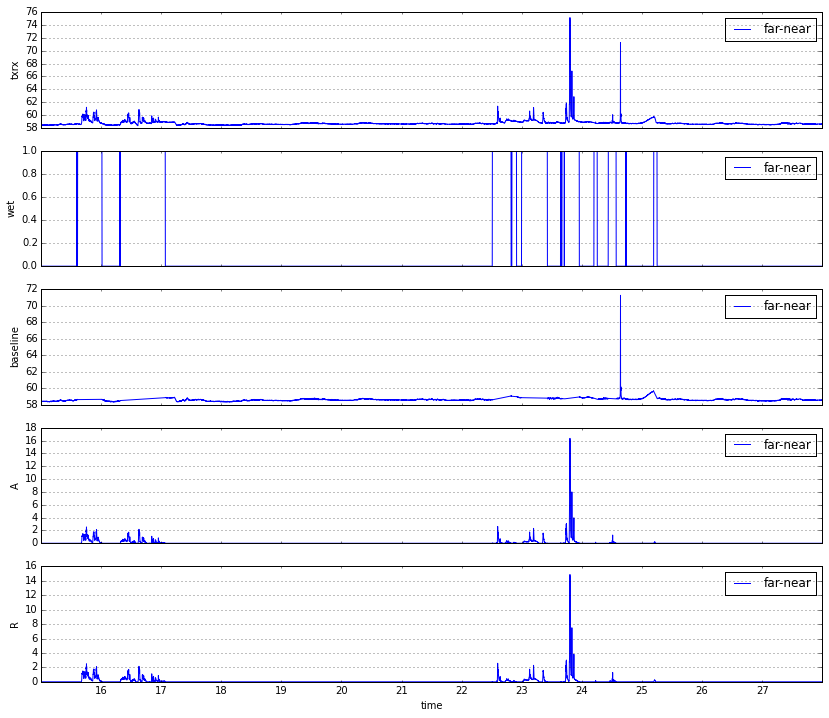

In [33]:
cml.plot(('txrx', 'wet', 'baseline', 'A', 'R'),
         figsize=(14,12));